## This is code for adding

### Imports and preloading

In [1]:
# import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
import torch.optim as optim
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
path="../../input/final_split_training_augmented/train"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # You can test the normalization but if u apply remember to apply for testing
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

allDataSet = datasets.ImageFolder(root=path, transform=transform)
totalSize = len(allDataSet)
reductionRatio = 1
reducedSize = int(totalSize * reductionRatio)
indices = list(range(totalSize))
random.shuffle(indices)
reduced_indices = indices[:reducedSize]
reducedDataset = Subset(allDataSet, reduced_indices)

print(f"Reduced Train: {len(reducedDataset)}")
dataloader = DataLoader(reducedDataset, batch_size=32, shuffle=True, drop_last=True)


Reduced Train: 8025


In [3]:
path="../../input/final_split_training_augmented/eval"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

evalSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Reduced Train: {len(evalSet)}")
valLoader = DataLoader(evalSet, batch_size=32, shuffle=True)


Reduced Train: 579


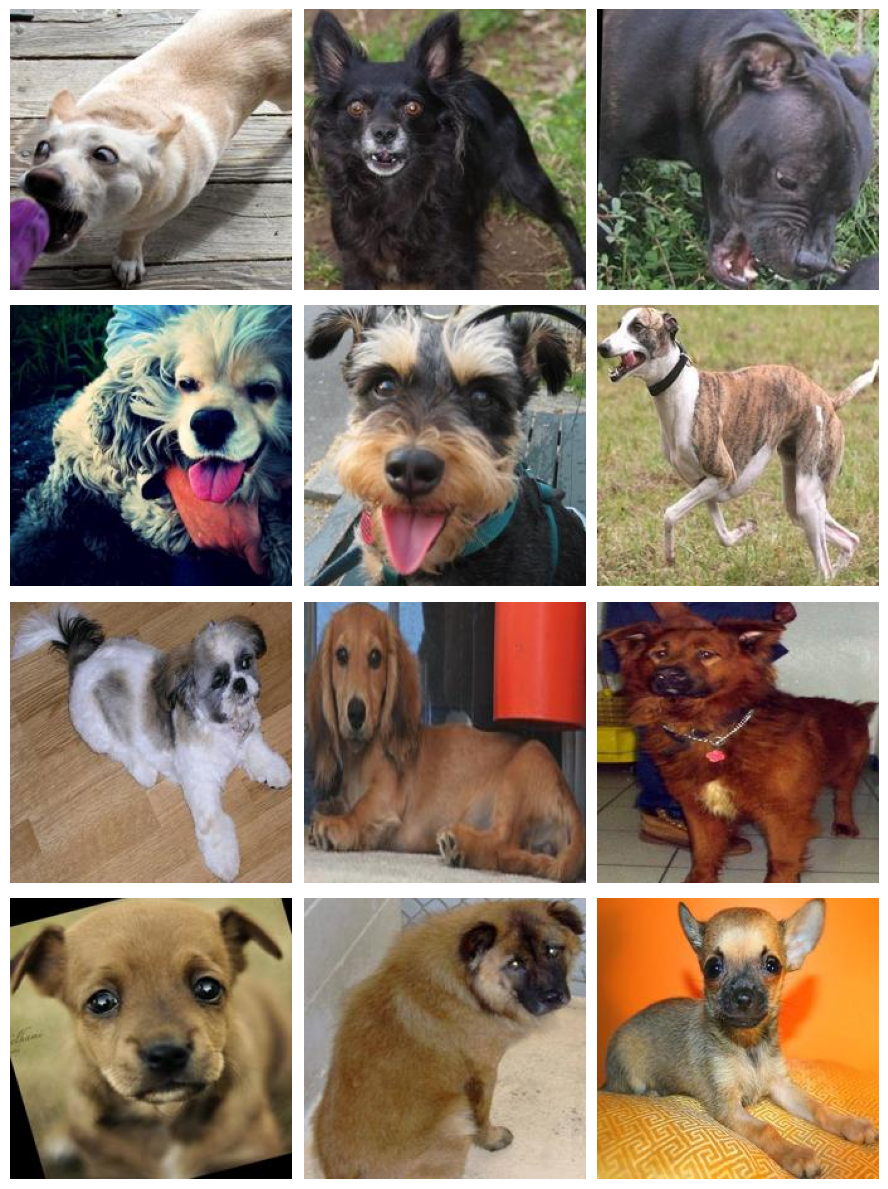

In [16]:
import matplotlib.pyplot as plt
from collections import defaultdict
import torchvision

# Group images by class index
class_samples = defaultdict(list)

# Number of classes
num_classes = len(evalSet.classes)
samples_per_class = 3

# Collect samples
for img, label in evalSet:
    if len(class_samples[label]) < samples_per_class:
        class_samples[label].append(img)

    # Only break if all classes have enough samples
    if len(class_samples) == num_classes and all(len(v) == samples_per_class for v in class_samples.values()):
        break

# Map class index to class names
idx_to_class = {v: k for k, v in evalSet.class_to_idx.items()}

# Plot the images
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))

for row_idx, class_idx in enumerate(sorted(class_samples.keys())):
    images = class_samples[class_idx]
    for col_idx, image in enumerate(images):
        ax = axes[row_idx, col_idx] if num_classes > 1 else axes[col_idx]
        img_np = image.permute(1, 2, 0).numpy()
        ax.imshow(img_np)
        ax.axis("off")
        if col_idx == 0:
            ax.set_ylabel(idx_to_class[class_idx], fontsize=12)

plt.tight_layout()
plt.show()


In [4]:
# Number of classes in your dataset
num_classes = len(reducedDataset.dataset.classes) 
print(num_classes)

4


### Code Strucutre

In [6]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(

        )
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)    

class CustomENB5(nn.Module):
    def __init__(self,num_classes):
        super(CustomENB5, self).__init__()
        WeightsEnum.get_state_dict = get_state_dict

        self.base = efficientnet_b5(weights="DEFAULT")
        for param in self.base.parameters():
            param.requires_grad = False
            
        for name, param in self.base.named_parameters():
            if "features.6" in name or "features.7" in name:  # fine-tune last few blocks
                param.requires_grad = True
            
        
        self.seAfterFeature = SqueezeExcitationBlock(
            channels=2048
        )

        self.base.classifier = nn.Sequential(
            nn.Unflatten(1, (2048, 1, 1)),         
            SqueezeExcitationBlock(2048),
            nn.Flatten(),                            
            nn.Dropout(p=0.4),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.base.features(x)
        x = self.seAfterFeature(x)
        x = self.base.avgpool(x)
        x = torch.flatten(x,1)
        x = self.base.classifier(x)
        return x        
    
model = CustomENB5(num_classes)

optimizer = optim.Adam(model.base.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

CustomENB5(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

### Training

In [7]:
epochs = 10
best_val_acc = 0.0
patience = 3
trigger_times = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    epochLoss = running_loss / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/total:.4f} Accuracy: {acc:.4f}")
    train_losses.append(epochLoss)

    model.eval()
    eval_loss = 0.0
    eval_correct = 0
    eval_total = 0

    with torch.no_grad():
        for images, labels in valLoader:  # assumes valLoader is defined
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

    valLoss = eval_loss / eval_total
    val_acc = eval_correct / eval_total
    val_losses.append(valLoss)
    print(f"Eval  Loss: {valLoss:.4f} | Accuracy: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), "../../models/unclean/SEafterFeaturesInClassifier.pth")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger {trigger_times}/{patience}")

        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/10] Loss: 1.1987 Accuracy: 0.5331
Eval  Loss: 1.2336 | Accuracy: 0.4646
Epoch [2/10] Loss: 0.9618 Accuracy: 0.6498
Eval  Loss: 1.1966 | Accuracy: 0.4646
No improvement. Trigger 1/3
Epoch [3/10] Loss: 0.8063 Accuracy: 0.7070
Eval  Loss: 1.1865 | Accuracy: 0.4819
Epoch [4/10] Loss: 0.6692 Accuracy: 0.7781
Eval  Loss: 1.1875 | Accuracy: 0.4836
Epoch [5/10] Loss: 0.5221 Accuracy: 0.8539
Eval  Loss: 1.1879 | Accuracy: 0.4836
No improvement. Trigger 1/3
Epoch [6/10] Loss: 0.3805 Accuracy: 0.9169
Eval  Loss: 1.1969 | Accuracy: 0.4853
Epoch [7/10] Loss: 0.2633 Accuracy: 0.9651
Eval  Loss: 1.2099 | Accuracy: 0.4836
No improvement. Trigger 1/3
Epoch [8/10] Loss: 0.1783 Accuracy: 0.9856
Eval  Loss: 1.2372 | Accuracy: 0.4905
Epoch [9/10] Loss: 0.1210 Accuracy: 0.9954
Eval  Loss: 1.2549 | Accuracy: 0.4957
Epoch [10/10] Loss: 0.0833 Accuracy: 0.9971
Eval  Loss: 1.2807 | Accuracy: 0.4991


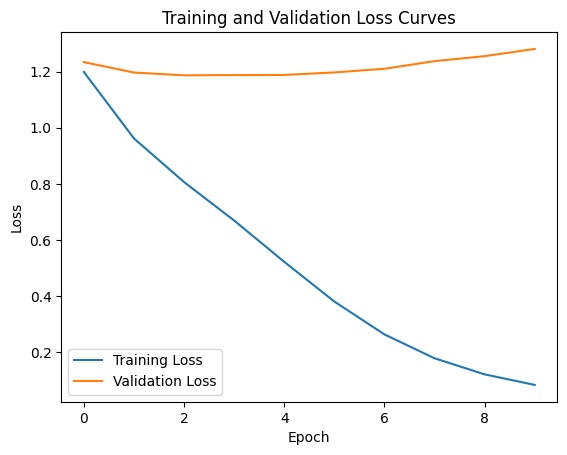

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


### Testing

In [9]:
path="../../input/final_split_training_augmented/test"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

allTestSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Test set: {len(allTestSet)}")
dataloader = DataLoader(allTestSet, batch_size=32, shuffle=True)


Test set: 572


In [10]:
# Number of classes in your dataset
num_classes = len(dataloader.dataset.classes) 
print(num_classes)

4


In [12]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(

        )
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)    

class CustomENB5(nn.Module):
    def __init__(self,num_classes):
        super(CustomENB5, self).__init__()
        WeightsEnum.get_state_dict = get_state_dict

        self.base = efficientnet_b5(weights="DEFAULT")
        for param in self.base.parameters():
            param.requires_grad = False
            
        for name, param in self.base.named_parameters():
            if "features.6" in name or "features.7" in name:  # fine-tune last few blocks
                param.requires_grad = True
            
        
        self.seAfterFeature = SqueezeExcitationBlock(
            channels=2048
        )

        self.base.classifier = nn.Sequential(
            nn.Unflatten(1, (2048, 1, 1)),         
            SqueezeExcitationBlock(2048),
            nn.Flatten(),                            
            nn.Dropout(p=0.4),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.base.features(x)
        x = self.seAfterFeature(x)
        x = self.base.avgpool(x)
        x = torch.flatten(x,1)
        x = self.base.classifier(x)
        return x        
    
model = CustomENB5(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
model.load_state_dict(torch.load("../../models/unclean/SEafterFeaturesInClassifier.pth"))
model.eval()


CustomENB5(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [13]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

target_names = allTestSet.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.7255
Classification Report:
              precision    recall  f1-score   support

       angry       0.80      0.74      0.77       140
       happy       0.70      0.80      0.75       148
     relaxed       0.64      0.58      0.61       146
         sad       0.77      0.78      0.77       138

    accuracy                           0.73       572
   macro avg       0.73      0.73      0.73       572
weighted avg       0.73      0.73      0.72       572

Confusion Matrix:
[[104  17  12   7]
 [  9 118  17   4]
 [ 10  29  85  22]
 [  7   4  19 108]]
